# Imports

In [ ]:
!pip install gdown
!gdown 10Y7wIyvrwW-ZqJGS48jnVv8UV7u41ic2 
!gdown 10WJXFBvAzHsK9ZmEMt9UwJeQRdUXNCPc
!gdown 10Uo8vvI2ZsKVjx_o1JaMOqfOzW6WmWk_
!gdown 10SZCr_KxXHjJ_BvDfah4AVbu03BuS27M

In [1]:
%cd D:\desk top folders\ML\MachineLearning2024W\Projects\mini project 2\Dataset

D:\desk top folders\ML\MachineLearning2024W\Projects\mini project 2\Dataset


In [2]:
from sklearn.model_selection import train_test_split
from  sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
import numpy as np
import seaborn as sns
import  scipy
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import tqdm
import os

In [3]:
# Load the .mat file
# fault1_mat = loadmat('/content/IR007.mat')
# fault2_mat = loadmat('/content/B007.mat')
# fault3_mat = loadmat('/content/OR007.mat')
# normal_mat = loadmat('/content/Normal.mat')

fault1_mat = loadmat('./IR007.mat')
fault2_mat = loadmat('./B007.mat')
fault3_mat = loadmat('./OR007.mat')
normal_mat = loadmat('./Normal.mat')

In [4]:
print(fault1_mat.keys(),"\n")
print(fault2_mat.keys(),"\n")
print(fault3_mat.keys(),"\n")
print(normal_mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X106_DE_time', 'X106_FE_time', 'X106_BA_time', 'X106RPM']) 

dict_keys(['__header__', '__version__', '__globals__', 'X119_DE_time', 'X119_FE_time', 'X119_BA_time', 'X119RPM']) 

dict_keys(['__header__', '__version__', '__globals__', 'X131_DE_time', 'X131_FE_time', 'X131_BA_time', 'X131RPM']) 

dict_keys(['__header__', '__version__', '__globals__', 'X098_DE_time', 'X098_FE_time'])


# Section2


## Data Selection

In [5]:
normal_data = normal_mat['X098_DE_time']
print(normal_data.shape)

fault1_data = fault1_mat['X106_DE_time']
print(fault1_data.shape)

fault2_data = fault2_mat['X119_DE_time']
print(fault2_data.shape)

fault3_data = fault3_mat['X131_DE_time']
print(fault3_data.shape)

(483903, 1)
(121991, 1)
(121410, 1)
(122426, 1)


In [6]:
n_samples = 600
len_data = 200

normal_data_matrix = normal_data[:-(normal_data.shape[0] % len_data)].reshape(-1, len_data)
fault1_data_matrix = fault1_data[:-(fault1_data.shape[0] % len_data)].reshape(-1, len_data)
fault2_data_matrix = fault2_data[:-(fault2_data.shape[0] % len_data)].reshape(-1, len_data)
fault3_data_matrix = fault3_data[:-(fault3_data.shape[0] % len_data)].reshape(-1, len_data)

print("Before choose samples")
print(normal_data_matrix.shape)
print(fault1_data_matrix.shape)
print(fault2_data_matrix.shape)
print(fault3_data_matrix.shape)

print("\nAfter choose samples")
normal_data_matrix = normal_data_matrix[:n_samples,:]
fault1_data_matrix = fault1_data_matrix[:n_samples,:]
fault2_data_matrix = fault2_data_matrix[:n_samples,:]
fault3_data_matrix = fault3_data_matrix[:n_samples,:]
print(normal_data_matrix.shape)
print(fault1_data_matrix.shape)
print(fault2_data_matrix.shape)
print(fault3_data_matrix.shape)

Before choose samples
(2419, 200)
(609, 200)
(607, 200)
(612, 200)

After choose samples
(600, 200)
(600, 200)
(600, 200)
(600, 200)


## Feature Extraction

In [7]:
def feature_extraction(data):
    features = {}

    # Standard Deviation
    features['Standard Deviation'] = np.std(data, axis=1)

    # Peak
    features['Peak'] = np.max(np.abs(data), axis=1)

    # Skewness
    features['Skewness'] = scipy.stats.skew(data, axis=1)

    # Kurtosis
    features['Kurtosis'] = scipy.stats.kurtosis(data, axis=1)

    # Crest Factor (peak divided by RMS)
    rms = np.sqrt(np.mean(np.square(data), axis=1))
    features['Crest Factor'] = features['Peak'] / rms

    # Clearance Factor (peak divided by the mean of the square root of the absolute values)
    features['Clearance Factor'] = features['Peak'] / np.mean(np.sqrt(np.abs(data)), axis=1)

    # Peak to Peak
    features['Peak to Peak'] = np.ptp(data, axis=1)

    # Shape Factor (RMS divided by the mean of the absolute values)
    features['Shape Factor'] = rms / np.mean(np.abs(data), axis=1)

    # Impact Factor (peak divided by mean)
    features['Impact Factor'] = features['Peak'] / np.mean(data, axis=1)

    # Square Mean Root (the square root of the mean of the squares)
    features['Square Mean Root'] = rms

    # Mean
    features['Mean'] = np.mean(data, axis=1)

    # Absolute Mean
    features['Absolute Mean'] = np.mean(np.abs(data), axis=1)

    # Root Mean Square
    features['Root Mean Square'] = rms

    # Impulse Factor (peak divided by the absolute mean)
    features['Impulse Factor'] = features['Peak'] / features['Absolute Mean']

    return features

In [8]:
normal_features = pd.DataFrame(feature_extraction(normal_data_matrix))
fault1_features = pd.DataFrame(feature_extraction(fault1_data_matrix))
fault2_features = pd.DataFrame(feature_extraction(fault2_data_matrix))
fault3_features = pd.DataFrame(feature_extraction(fault3_data_matrix))
normal_features['Label'] = 0
fault1_features['Label'] = 1
fault2_features['Label'] = 2
fault3_features['Label'] = 3

selected_features = ['Standard Deviation', 'Peak', 'Skewness', 'Kurtosis',
                     'Crest Factor', 'Mean', 'Root Mean Square',
                     'Impulse Factor','Square Mean Root','Shape Factor','Label']

main_df = pd.concat([normal_features, fault1_features, fault2_features, fault3_features], ignore_index=True)
df = main_df[selected_features]
main_df.shape

(2400, 15)

## Shuffling and Split Dataset

In [9]:
df_shuffled = df.sample(frac=1).reset_index(drop=True)

X = df_shuffled.drop('Label', axis=1)
y = df_shuffled['Label']

# X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=53)
# X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_train_raw, y_train, test_size=0.25, random_state=53)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=53)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_train_raw, y_train, test_size=0.25, stratify=y_train, random_state=53)


print("training set:", X_train_raw.shape,  y_train.shape)
print("validation set:",X_val_raw.shape, y_val.shape)
print("test set:",X_test_raw.shape, y_test.shape)


training set: (1440, 10) (1440,)
validation set: (480, 10) (480,)
test set: (480, 10) (480,)


## Normalization

In [10]:
def min_max_normalization(data, max_val=None, min_val = None):
    if max_val is None:
        min_val = data.min()
        max_val = data.max()
    return (data - min_val) / (max_val - min_val), max_val, min_val

X_train, X_train_max, X_train_min = min_max_normalization(X_train_raw)
X_test, _, _ = min_max_normalization(X_test_raw,X_train_max,X_train_min)
X_val, _, _ = min_max_normalization(X_val_raw,X_train_max,X_train_min)

X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_val = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)

y_train = torch.tensor(y_train.to_numpy(), dtype=torch.long)
y_val = torch.tensor(y_val.to_numpy(), dtype=torch.long)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# Perform one-hot encoding
y_train = torch.nn.functional.one_hot(y_train, num_classes=4).float()
y_val = torch.nn.functional.one_hot(y_val, num_classes=4).float()
y_test = torch.nn.functional.one_hot(y_test, num_classes=4).float()





# Model

In [11]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 32)
        self.hidden2 = nn.Linear(32, 64)
        self.output = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.output(x)
        x = self.softmax(x)
        return x

## Initialize

In [12]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# Initialize the model, loss function, and optimizer
model = MLP(input_dim=X_train.shape[1], output_dim=len(set(y)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=15, verbose=True)


# Section 2

## Train

In [13]:
# Training loop with early stopping
num_epochs = 500
patience = 30
best_val_loss = float('inf')
epochs_without_improvement = 0
Best_model = None

# Metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        _, targets = torch.max(labels,1)
        train_correct += (preds == targets).sum().item()
        total_train += labels.size(0)

    train_loss /= len(train_loader)
    train_accuracy = train_correct / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            _, targets = torch.max(labels,1)
            val_correct += (preds == targets).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

    scheduler.step(val_loss)
    
    if  best_val_loss - val_loss > 1e-3:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping triggered after {epoch+1} epochs.')
        break
    
metrics_df_CE_ADAM = pd.DataFrame({
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_accuracy': train_accuracies,
    'val_accuracy': val_accuracies
}).to_csv('training_metrics.csv', index=False)

Epoch 1/500, Train Loss: 1.3813, Val Loss: 1.3792, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 2/500, Train Loss: 1.3781, Val Loss: 1.3762, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 3/500, Train Loss: 1.3753, Val Loss: 1.3731, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 4/500, Train Loss: 1.3720, Val Loss: 1.3695, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 5/500, Train Loss: 1.3684, Val Loss: 1.3655, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 6/500, Train Loss: 1.3642, Val Loss: 1.3609, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 7/500, Train Loss: 1.3592, Val Loss: 1.3558, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 8/500, Train Loss: 1.3543, Val Loss: 1.3499, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 9/500, Train Loss: 1.3479, Val Loss: 1.3432, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 10/500, Train Loss: 1.3412, Val Loss: 1.3357, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 11/500, Train Loss: 1.3326, Val L

### Metrics

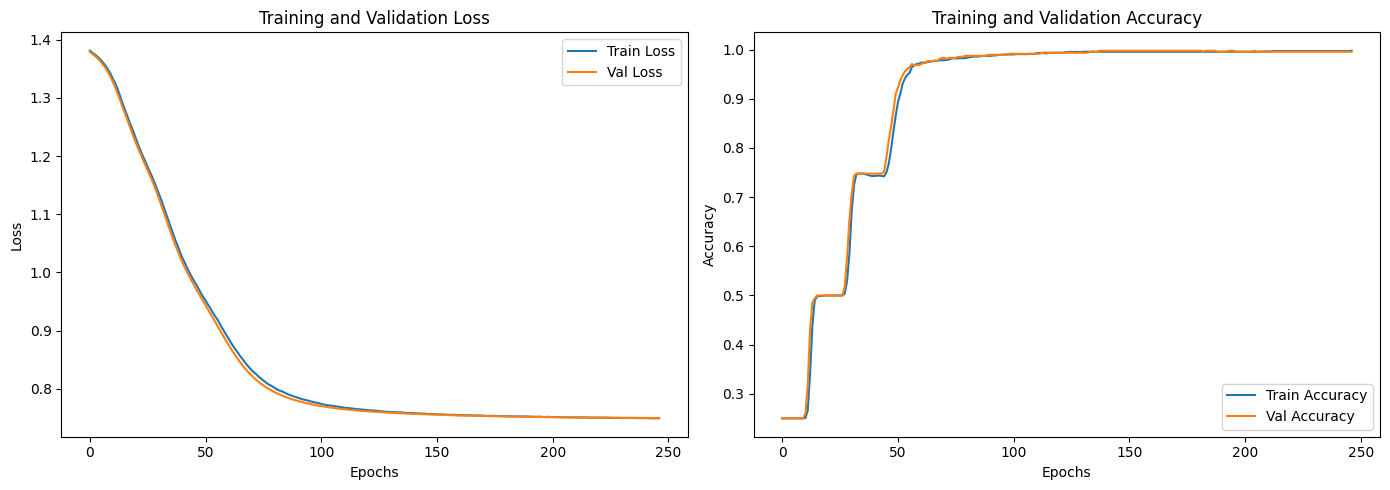

In [14]:
plt.figure(figsize=(14, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy')
plt.plot(range(len(val_accuracies)), val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Inference

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 2.
    # Correcting the loop below
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Train

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       360
           1       0.99      1.00      1.00       360
           2       0.99      1.00      1.00       360
           3       1.00      0.99      1.00       360

    accuracy                           1.00      1440
   macro avg       1.00      1.00      1.00      1440
weighted avg       1.00      1.00      1.00      1440



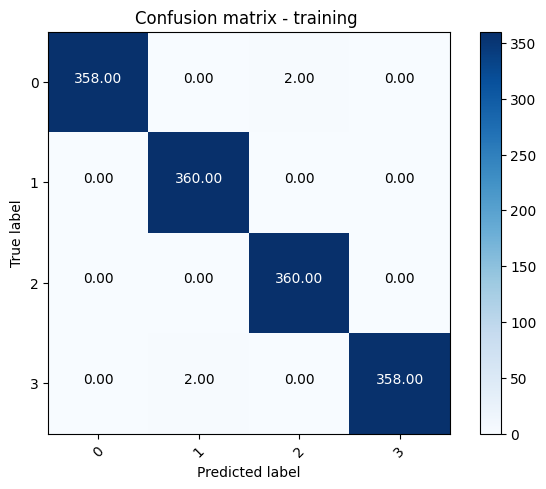

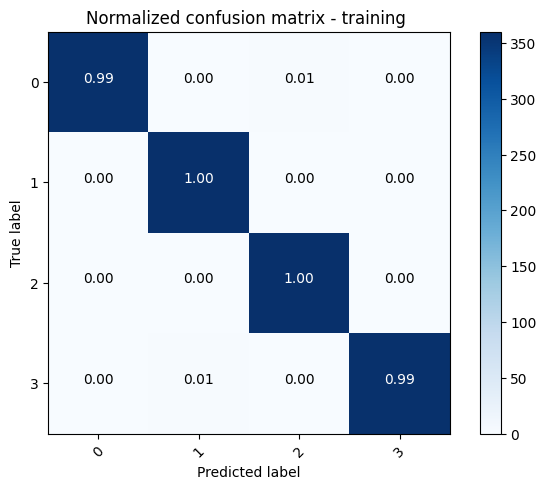

In [21]:
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_true = [torch.argmax(torch.tensor(label)).item() for label in y_true]

# Convert y_pred to integer labels
y_pred = [pred for pred in y_pred]

# Classification report and confusion matrix
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm ,classes=[0, 1, 2, 3], title='Confusion matrix - training ')
plot_confusion_matrix(cm ,classes=[0, 1, 2, 3], normalize=True, title='Normalized confusion matrix - training ')


### Val

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       120
           1       0.99      1.00      1.00       120
           2       1.00      0.99      1.00       120
           3       1.00      0.99      1.00       120

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



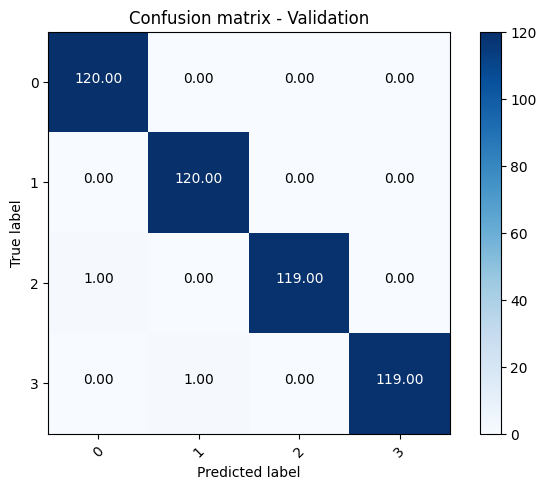

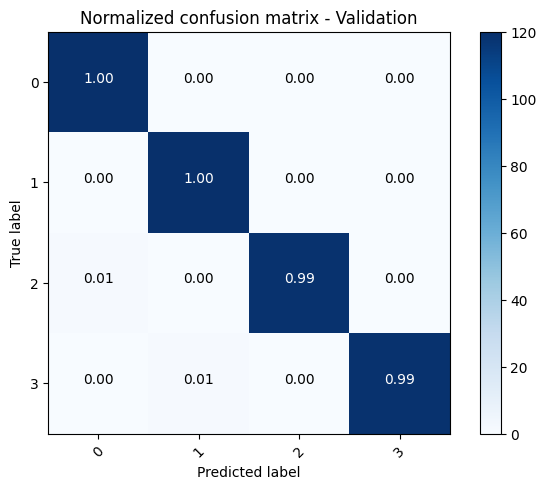

In [22]:
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_true = [torch.argmax(torch.tensor(label)).item() for label in y_true]

# Convert y_pred to integer labels
y_pred = [pred for pred in y_pred]

# Classification report and confusion matrix
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm ,classes=[0, 1, 2, 3], title='Confusion matrix - Validation')
plot_confusion_matrix(cm ,classes=[0, 1, 2, 3], normalize=True, title='Normalized confusion matrix - Validation')


### Test

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       1.00      1.00      1.00       120
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       120

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



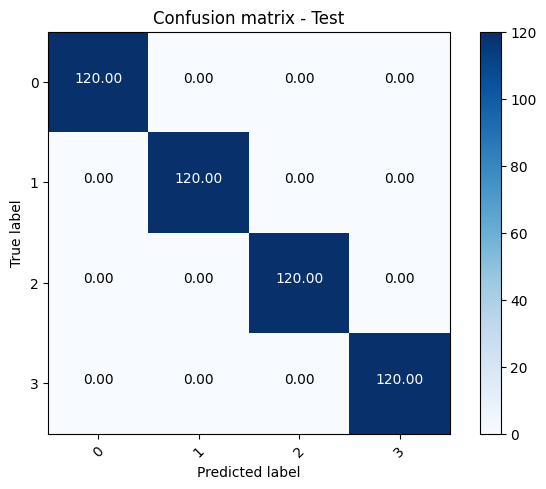

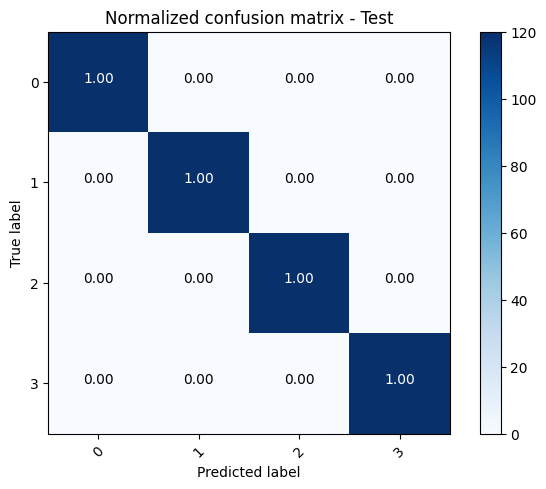

In [23]:
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_true = [torch.argmax(torch.tensor(label)).item() for label in y_true]

# Convert y_pred to integer labels
y_pred = [pred for pred in y_pred]

# Classification report and confusion matrix
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm ,classes=[0, 1, 2, 3], title='Confusion matrix - Test')
plot_confusion_matrix(cm ,classes=[0, 1, 2, 3], normalize=True, title='Normalized confusion matrix - Test')


# Section 3

## Initialize

In [32]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Initialize the model, loss function, and optimizer
model = MLP(input_dim=X_train.shape[1], output_dim=len(set(y)))
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=15, verbose=True)


## Train

In [33]:

# Training loop with early stopping
num_epochs = 500
patience = 500
best_val_loss = float('inf')
epochs_without_improvement = 0
Best_model = None

# Metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        _, targets = torch.max(labels,1)
        train_correct += (preds == targets).sum().item()
        total_train += labels.size(0)

    train_loss /= len(train_loader)
    train_accuracy = train_correct / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            _, targets = torch.max(labels,1)
            val_correct += (preds == targets).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

    scheduler.step(val_loss)
    
    if  best_val_loss - val_loss > 1e-6:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping triggered after {epoch+1} epochs.')
        break
    
metrics_df_ADAM_L1Loss = pd.DataFrame({
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_accuracy': train_accuracies,
    'val_accuracy': val_accuracies
})

Epoch 1/500, Train Loss: 0.3182, Val Loss: 0.3381, Train Accuracy: 0.3354, Val Accuracy: 0.2958
Epoch 2/500, Train Loss: 0.2727, Val Loss: 0.2475, Train Accuracy: 0.4271, Val Accuracy: 0.5021
Epoch 3/500, Train Loss: 0.2325, Val Loss: 0.2058, Train Accuracy: 0.5222, Val Accuracy: 0.6000
Epoch 4/500, Train Loss: 0.1895, Val Loss: 0.1407, Train Accuracy: 0.6479, Val Accuracy: 0.7333
Epoch 5/500, Train Loss: 0.1470, Val Loss: 0.1367, Train Accuracy: 0.7153, Val Accuracy: 0.7271
Epoch 6/500, Train Loss: 0.1347, Val Loss: 0.1285, Train Accuracy: 0.7319, Val Accuracy: 0.7458
Epoch 7/500, Train Loss: 0.1299, Val Loss: 0.1275, Train Accuracy: 0.7417, Val Accuracy: 0.7458
Epoch 8/500, Train Loss: 0.1282, Val Loss: 0.1299, Train Accuracy: 0.7444, Val Accuracy: 0.7438
Epoch 9/500, Train Loss: 0.1266, Val Loss: 0.1274, Train Accuracy: 0.7465, Val Accuracy: 0.7458
Epoch 10/500, Train Loss: 0.1275, Val Loss: 0.1263, Train Accuracy: 0.7472, Val Accuracy: 0.7479
Epoch 11/500, Train Loss: 0.1263, Val L

In [34]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Initialize the model, loss function, and optimizer
model = MLP(input_dim=X_train.shape[1], output_dim=len(set(y)))
criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=15, verbose=True)


In [35]:

# Training loop with early stopping
num_epochs = 500
patience = 500
best_val_loss = float('inf')
epochs_without_improvement = 0
Best_model = None

# Metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        _, targets = torch.max(labels,1)
        train_correct += (preds == targets).sum().item()
        total_train += labels.size(0)

    train_loss /= len(train_loader)
    train_accuracy = train_correct / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            _, targets = torch.max(labels,1)
            val_correct += (preds == targets).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

    scheduler.step(val_loss)
    
    if  best_val_loss - val_loss > 1e-6:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping triggered after {epoch+1} epochs.')
        break
    
metrics_df_SGD_L1Loss = pd.DataFrame({
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_accuracy': train_accuracies,
    'val_accuracy': val_accuracies
})

Epoch 1/500, Train Loss: 0.3731, Val Loss: 0.3729, Train Accuracy: 0.2528, Val Accuracy: 0.2500
Epoch 2/500, Train Loss: 0.3729, Val Loss: 0.3728, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 3/500, Train Loss: 0.3727, Val Loss: 0.3726, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 4/500, Train Loss: 0.3725, Val Loss: 0.3724, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 5/500, Train Loss: 0.3723, Val Loss: 0.3721, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 6/500, Train Loss: 0.3721, Val Loss: 0.3719, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 7/500, Train Loss: 0.3719, Val Loss: 0.3717, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 8/500, Train Loss: 0.3717, Val Loss: 0.3715, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 9/500, Train Loss: 0.3715, Val Loss: 0.3713, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 10/500, Train Loss: 0.3712, Val Loss: 0.3710, Train Accuracy: 0.2500, Val Accuracy: 0.2500
Epoch 11/500, Train Loss: 0.3710, Val L

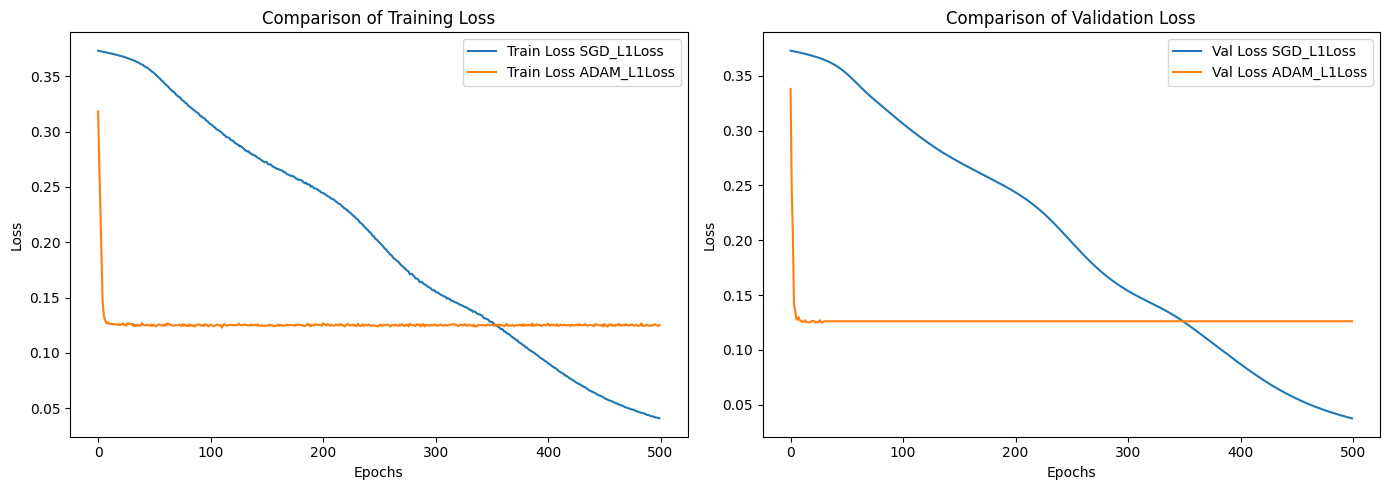

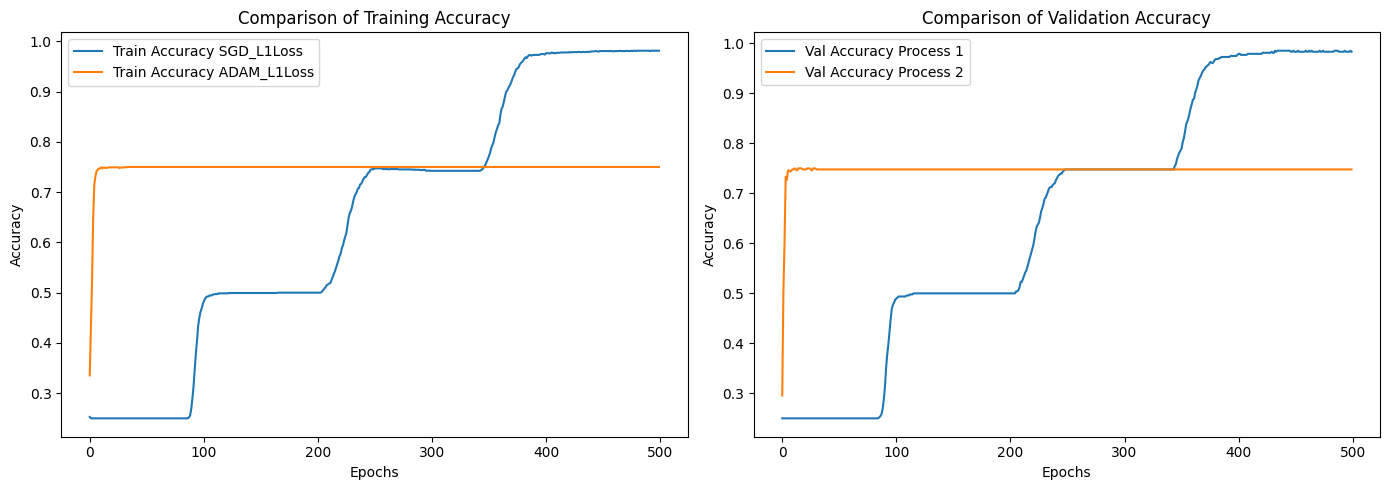

In [36]:

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(metrics_df_SGD_L1Loss['train_loss'], label='Train Loss SGD_L1Loss')
plt.plot(metrics_df_ADAM_L1Loss['train_loss'], label='Train Loss ADAM_L1Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Training Loss')
plt.legend()

# Plot comparison of validation loss
plt.subplot(1, 2, 2)
plt.plot(metrics_df_SGD_L1Loss['val_loss'], label='Val Loss SGD_L1Loss')
plt.plot(metrics_df_ADAM_L1Loss['val_loss'], label='Val Loss ADAM_L1Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot comparison of train accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(metrics_df_SGD_L1Loss['train_accuracy'], label='Train Accuracy SGD_L1Loss')
plt.plot(metrics_df_ADAM_L1Loss['train_accuracy'], label='Train Accuracy ADAM_L1Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of Training Accuracy')
plt.legend()

# Plot comparison of validation accuracy
plt.subplot(1, 2, 2)
plt.plot(metrics_df_SGD_L1Loss['val_accuracy'], label='Val Accuracy Process 1')
plt.plot(metrics_df_ADAM_L1Loss['val_accuracy'], label='Val Accuracy Process 2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Inference

### Train


              precision    recall  f1-score   support

           0       0.99      0.96      0.98       360
           1       0.97      1.00      0.99       360
           2       0.96      0.99      0.98       360
           3       1.00      0.97      0.99       360

    accuracy                           0.98      1440
   macro avg       0.98      0.98      0.98      1440
weighted avg       0.98      0.98      0.98      1440



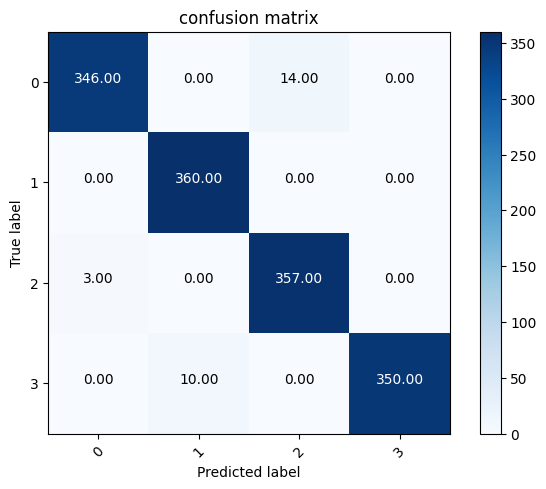

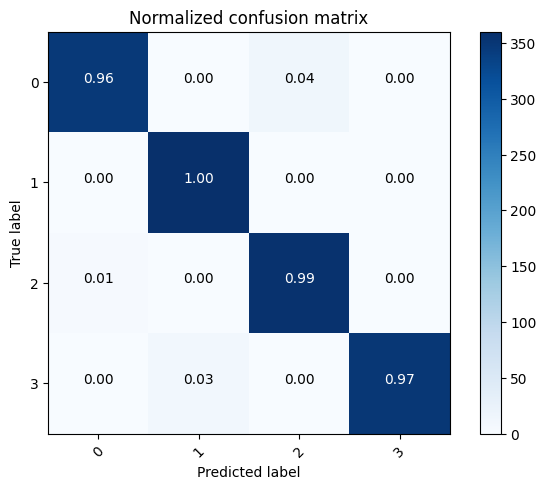

In [29]:
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_true = [torch.argmax(torch.tensor(label)).item() for label in y_true]

# Convert y_pred to integer labels
y_pred = [pred for pred in y_pred]

# Classification report and confusion matrix
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm ,classes=[0, 1, 2, 3], title='confusion matrix')
plot_confusion_matrix(cm ,classes=[0, 1, 2, 3], normalize=True, title='Normalized confusion matrix')


### Val


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       120
           1       0.99      1.00      1.00       120
           2       0.96      1.00      0.98       120
           3       1.00      0.99      1.00       120

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480



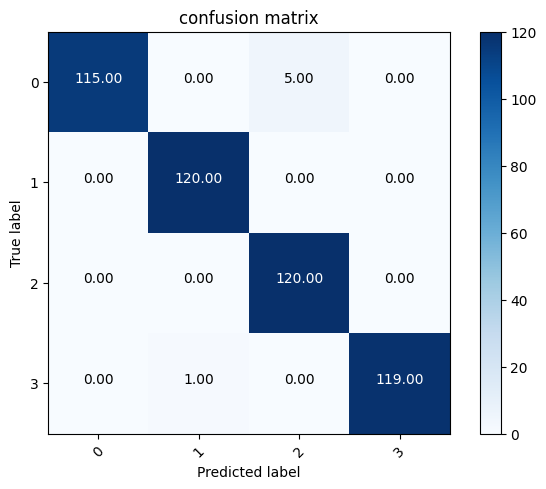

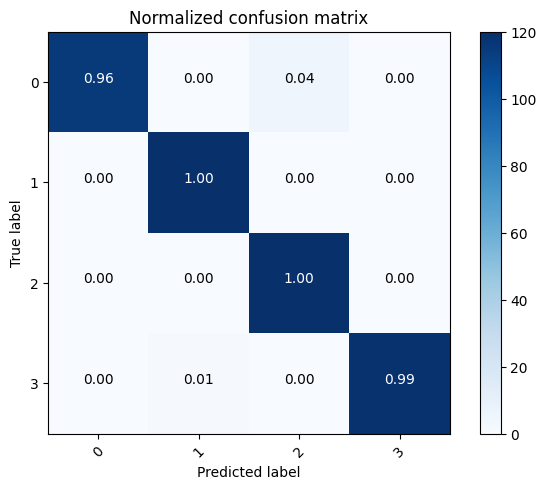

In [30]:
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_true = [torch.argmax(torch.tensor(label)).item() for label in y_true]

# Convert y_pred to integer labels
y_pred = [pred for pred in y_pred]

# Classification report and confusion matrix
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm ,classes=[0, 1, 2, 3], title='confusion matrix')
plot_confusion_matrix(cm ,classes=[0, 1, 2, 3], normalize=True, title='Normalized confusion matrix')


### Test

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       120
           1       0.99      1.00      1.00       120
           2       0.97      1.00      0.98       120
           3       1.00      0.99      1.00       120

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480



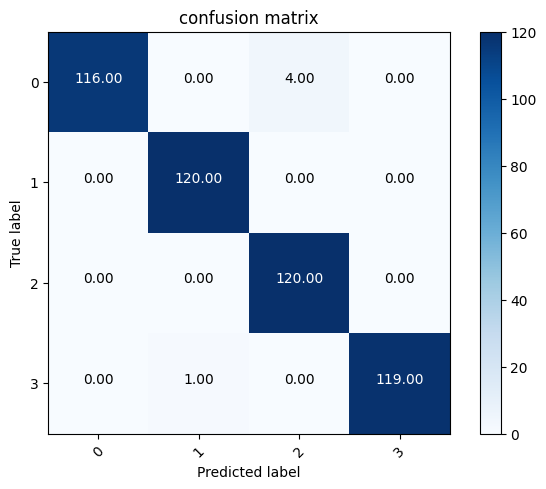

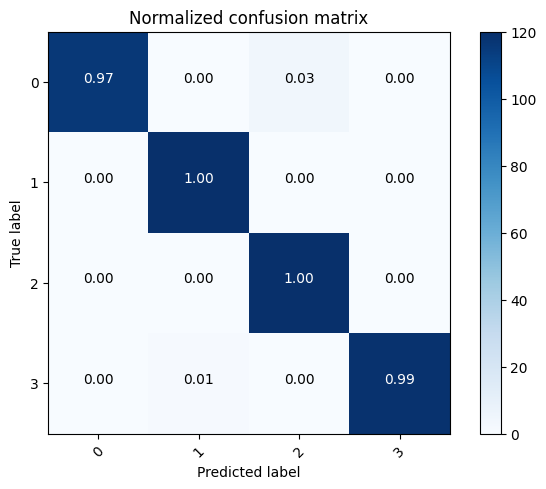

In [31]:
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_true = [torch.argmax(torch.tensor(label)).item() for label in y_true]

# Convert y_pred to integer labels
y_pred = [pred for pred in y_pred]

# Classification report and confusion matrix
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm ,classes=[0, 1, 2, 3], title='confusion matrix')
plot_confusion_matrix(cm ,classes=[0, 1, 2, 3], normalize=True, title='Normalized confusion matrix')
